# Wrapping and using DeepChem models #

In [1]:
# This gives Jupyter access to the SDK without having to install it

from pathlib import Path
import sys 
sys.path.append((Path.cwd().parent).as_posix())

### Loading the dataset ###
We download a chemical dataset from the Therapeutics Data Commons, then wrap it in our `alien.data.DeepChemDataset` class. We specify a featurizer, for converting SMILES strings to DeepChem graph structures. We can specify any string that matches (part of) any DeepChem featurizer class name.

In [2]:
from tdc.single_pred import ADME
from alien.data import DeepChemDataset

data = ADME(name = 'Caco2_Wang')
split = data.get_split()

train_data = DeepChemDataset(
    X=split['train']['Drug'], 
    y=list(split['train']['Y']), 
    featurizer='convmol'
)
test_data = DeepChemDataset(
    X=split['test']['Drug'], 
    y=list(split['test']['Y']), 
    featurizer='convmol'
)

Found local copy...
Loading...
Done!
2023-05-09 18:32:49.085511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 18:32:49.132258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 18:32:49.133132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 18:32:49.905080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.to

We split our training data into an initial labelled set to train the model on, and the remainder will be a pool for our active learning strategy to pick from:

In [3]:
n_labelled = int(.4 * len(train_data))
data_l = train_data[:n_labelled] # initial labelled data to train the model on
data_u = train_data[n_labelled:] # unlabelled sample pool to select from

### Building and wrapping the model ###
We construct a `GraphConvModel` within the DeepChem framework:

In [4]:
import deepchem as dc
import os

hyper_params = {
    'dense_layer_size': 50,
    'graph_conv_layers': [20, 20],
    'dropout': 0.1,
    'batch_size': 64,
    'learning_rate': 0.001
}

os.makedirs('deepchem_models', exist_ok=True)
dc_model = dc.models.GraphConvModel(
    1,
    batch_normalize=True,
    mode='regression',
    uncertainty=False,
    log_frequency=20,
    model_dir='deepchem_models/',
    **hyper_params
)


We wrap the DeepChem model in our `Regressor` class, which creates the tooling needed to use MC dropout to get covariances out of the model. We pass in the training set as well.

We use `uncertainty='dropout'`, which computes uncertainties using dropout layers during inference. Alternatively, we could use `uncertainty='laplace'`, which would get covariances using the Laplace approximation on the last layer weights.

In [5]:
from alien.models import Regressor

model = Regressor(dc_model, data_l, uncertainty='dropout')

Now we fit the model. This uses DeepChem's training code under the hood.

In [6]:
model.fit()

We could have called `model.fit(data_l)` or `model.fit(data_l.X, data_l.y)`, but there was no need, since the model already has the training set.

### Invoking the model ###
Now we get predictions and covariances from our test set:

In [7]:
pred = model.predict(test_data.X[:40])
cov = model.covariance(test_data.X[:40])

In [8]:
# Correlation from covariance:
def cor_from_cov(cov):
    std = 1 / np.sqrt(np.diag(cov))
    return std[:,None] * cov * std[None,:]

We plot correlations and covariances for our test set:

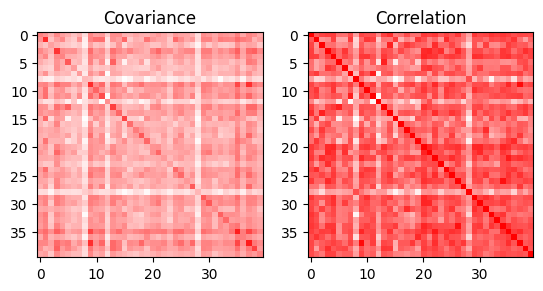

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1,2)

axes[0].set_title("Covariance")
axes[0].imshow(cov, cmap='bwr', vmin=-1, vmax=1, interpolation='nearest')

axes[1].set_title("Correlation")
axes[1].imshow(cor_from_cov(cov), cmap='bwr', vmin=-1, vmax=1, interpolation='nearest');

## Selector objects and batch selection ##
Now we build a selector object using the "max covariance" strategy (known as COVDROP when paired with MC dropout). `samples` and `batch_size` may instead be passed into the `.select` method later on.

In [10]:
from alien.selection import CovarianceSelector

selector = CovarianceSelector(
    model = model,
    samples = data_u,
    batch_size = 10,
    random_seed = 420,
)

Now we invoke the selection step. `batch` will contain just those rows of `data_u` that have been selected:

In [11]:
batch = selector.select() #return_indices=True)

If we like, we can get the selected indices instead:

In [12]:
selector.select(return_indices=True, verbose=False)

array([370, 227,  11, 299, 158,  15, 298, 115,  82, 261])

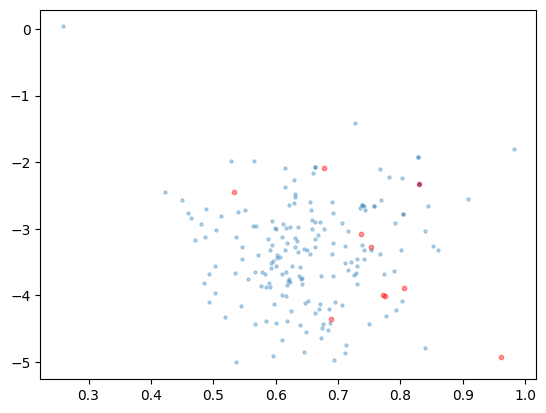

In [15]:
import matplotlib.pyplot as plt

pred = model.predict(test_data.X)
std_dev = np.sqrt(np.diagonal(model.covariance(test_data.X)))

batch_pred = model.predict(batch.X)
batch_std_dev = np.sqrt(np.diagonal(model.covariance(batch.X)))

plt.scatter(std_dev, pred, s=5, alpha=.3)
plt.scatter(batch_std_dev, batch_pred, c='red', s=10, alpha=.4)

We try another selection strategy, *B*atch *A*ctive learning via *I*nformation ma*T*rices (BAIT). This selector needs to know the samples that have previously been labelled, so we pass them in (during selector construction, or during the call to `.select`).

In [16]:
from alien.selection import BAITSelector

selector = BAITSelector(
    model = model,
    samples = data_u,
    labelled_samples = data_l,   # BAIT needs to know the labelled samples
    batch_size = 10,
)

batch = selector.select()

Greedy forward sampling...
Greedy backward pruning...
